In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Number of ImageNet classes: 1000
Class names: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_const

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:48, 24.48s/it]


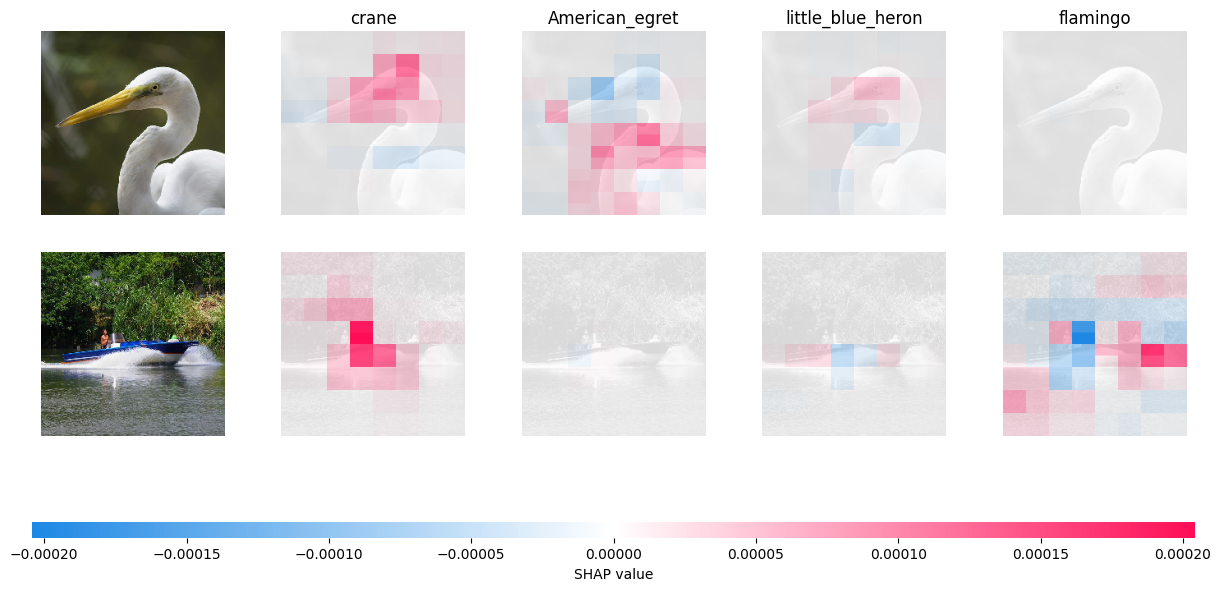

In [ ]:
import json
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap
import numpy as np
import matplotlib.pyplot as plt

# load pre-trained model and data
model = ResNet50(weights="imagenet")
X, y = shap.datasets.imagenet50()

# Assuming X[8] contains integer data that needs to be scaled to the range [0, 255]
X = np.clip(X, 0, 255).astype(np.uint8)

# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

print("Number of ImageNet classes:", len(class_names))
print("Class names:", class_names)

def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X[1:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)

# output with shap values
shap.image_plot(shap_values)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy

import warnings

warnings.filterwarnings("ignore")

In [ ]:
train_datasets = "/content/drive/MyDrive/Brain_MRI_dataset/Training/"
test_datasets = "/content/drive/MyDrive/Brain_MRI_dataset/Testing/"

In [ ]:
X_data, y_data = [], []
img_size = 150

# Load and preprocess data from training datasets
label_mapping = {'no_tumor': 0, 'glioma_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}

for label in os.listdir(train_datasets):
    img_files = os.listdir(os.path.join(train_datasets, label))
    for img_name in img_files:
        img_path = os.path.join(train_datasets, label, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (img_size, img_size))
            X_data.append(img_resized)
            y_data.append(label)

for label in os.listdir(test_datasets):
    img_files = os.listdir(os.path.join(test_datasets, label))
    for img_name in img_files:
        img_path = os.path.join(test_datasets, label, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (img_size, img_size))
            X_data.append(img_resized)
            y_data.append(label)

# Convert to numpy arrays
X_data = np.array(X_data) / 255.0

y_data = np.array([label_mapping[label] for label in y_data])

In [ ]:
print("X Data", X_data.shape)
print("y data", y_data.shape)

X Data (1697, 150, 150, 3)
y data (1697,)


In [ ]:
# One-hot encoding
y_data = to_categorical(y_data, num_classes=4)

In [ ]:
print("X Data", X_data.shape)
print("y data", y_data.shape)

X Data (1697, 150, 150, 3)
y data (1697, 4)


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state = 42)

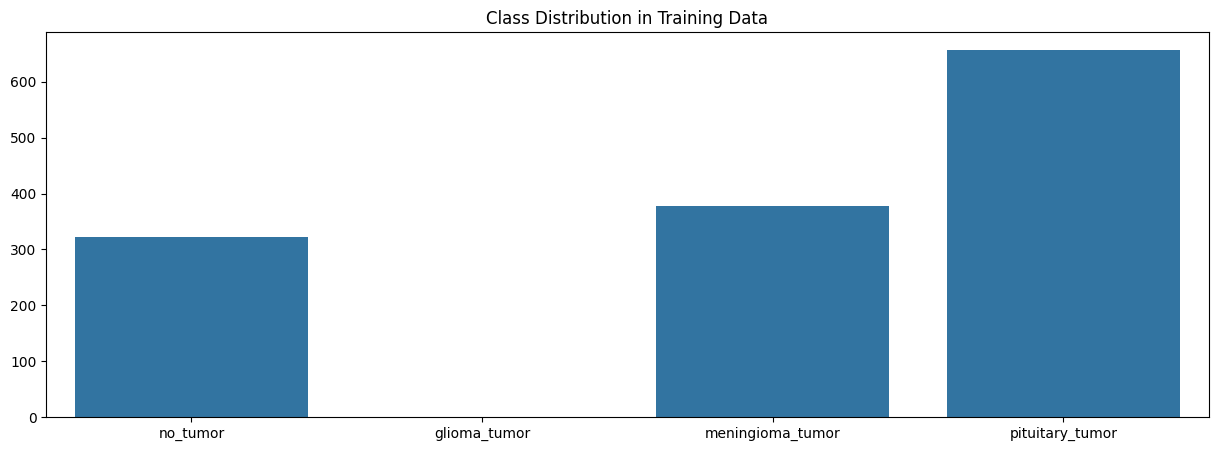

In [ ]:
# Visualization: Class distribution
class_counts = np.sum(y_train, axis=0)
plt.figure(figsize=(15, 5))
sns.barplot(x=list(label_mapping.keys()), y=class_counts)
plt.title("Class Distribution in Training Data")
plt.show()

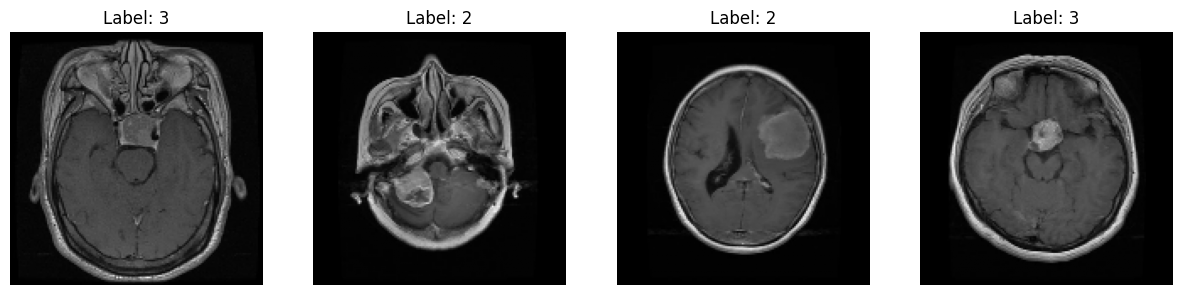

In [ ]:
# Visualization: Display random 4 images from the training set
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(X_train))
    ax.imshow(X_train[idx])
    ax.set_title(f"Label: {np.argmax(y_train[idx])}")
    ax.axis('off')
plt.show()

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)



datagen.fit(X_train)

In [ ]:
# Model architecture
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.3),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Activation

# model = Sequential([
#     Conv2D(32, (3, 3), padding='same', input_shape=(img_size, img_size, 3)),
#     BatchNormalization(),
#     Activation('relu'),
#     Conv2D(32, (3, 3), padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),

#     Conv2D(64, (3, 3), padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
#     Conv2D(64, (3, 3), padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.35),

#     Conv2D(128, (3, 3), padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
#     Conv2D(128, (3, 3), padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.4),

#     GlobalAveragePooling2D(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(4, activation='softmax')
# ])

In [ ]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras import Input

# # Input shape and number of classes
# img_size = 224  # standard input size for ResNet50
# num_classes = 4

# # Load ResNet50 without top classification layer
# base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

# # Freeze base model layers (initial training)
# base_model.trainable = False

# # Add custom layers on top
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# output = Dense(num_classes, activation='softmax')(x)

# # Final model
# model = Model(inputs=base_model.input, outputs=output)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary (optional)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 69, 69, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       921,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,075,012 (4.10 MB)

 Trainable params: 1,074,884 (4.10 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Compile model
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Resize images
# X_train_resized = tf.image.resize(X_train, [224, 224])
# X_test_resized = tf.image.resize(X_test, [224, 224])

In [ ]:
# Model training
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=20, verbose=1,
                    callbacks=[early_stopping]
                   )

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 540ms/step - accuracy: 0.4196 - loss: 1.1866 - val_accuracy: 0.5029 - val_loss: 1.2209
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step - accuracy: 0.6573 - loss: 0.8832 - val_accuracy: 0.5500 - val_loss: 1.0905
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.7018 - loss: 0.7014 - val_accuracy: 0.6176 - val_loss: 1.0592
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.6894 - loss: 0.7186 - val_accuracy: 0.6206 - val_loss: 0.9857
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.7032 - loss: 0.7208 - val_accuracy: 0.6000 - val_loss: 0.9665
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.7564 - loss: 0.6252 - val_accuracy: 0.7029 - val_loss: 0.8412
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.7760 - loss: 0.5679 - val_accuracy: 0.4471 - val_loss: 1.0196
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.7595 - loss: 0.5882 - val_accuracy:

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


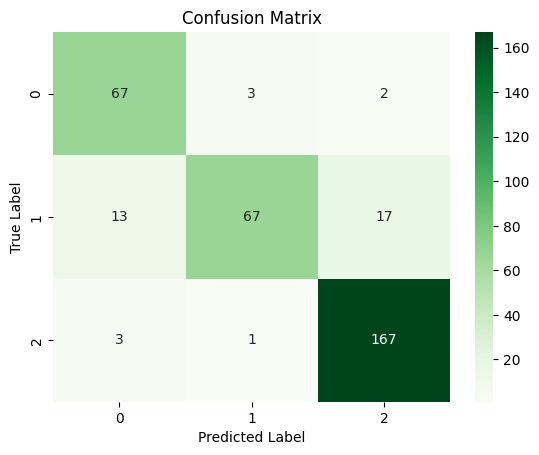

In [ ]:
# Model evaluation
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

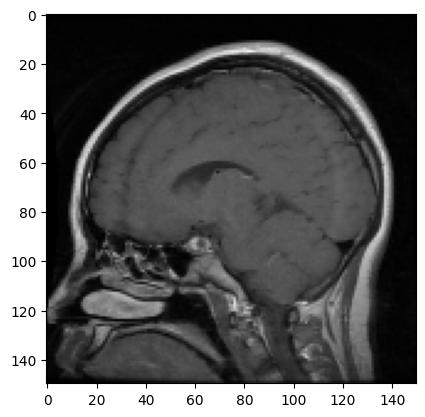

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X_test[0])
plt.show()

In [ ]:
import keras.backend as K
import numpy as np

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
# from tensorflow.keras.models import Model

# IMG_SIZE = 150  # or your preferred size

# base_model = ResNet50(
#     weights='imagenet',          # Transfer learning
#     include_top=False,
#     input_shape=(IMG_SIZE, IMG_SIZE, 3)
# )
# base_model.trainable = True    # Freeze for feature extraction first

# inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# x = base_model(inputs, training=False)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.4)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.3)(x)
# outputs = Dense(4, activation='softmax')(x)   # 4 classes—update if necessary
# model = Model(inputs, outputs)

# model.summary()

In [ ]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [ ]:
# # from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # datagen = ImageDataGenerator(
# #     rotation_range=20,
# #     width_shift_range=0.1,
# #     height_shift_range=0.1,
# #     zoom_range=0.2,
# #     horizontal_flip=True,
# #     fill_mode='nearest'
# # )
# # datagen.fit(X_train)

# # Data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     zoom_range=0.25,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
# )



In [ ]:
# history = model.fit(
#     datagen.flow(X_train, y_train, batch_size=32),
#     validation_data=(X_test, y_test),
#     epochs=20,
#     callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
# )

shap_arr.shape: (150, 150, 3, 4)
shap_map shape: (150, 150, 3)
shap_map_gray shape: (150, 150)


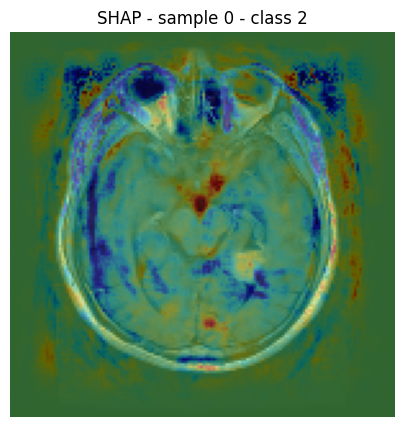

shap_arr.shape: (150, 150, 3, 4)
shap_map shape: (150, 150, 3)
shap_map_gray shape: (150, 150)


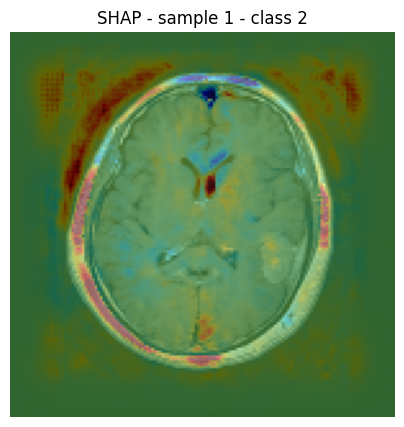

shap_arr.shape: (150, 150, 3, 4)
shap_map shape: (150, 150, 3)
shap_map_gray shape: (150, 150)


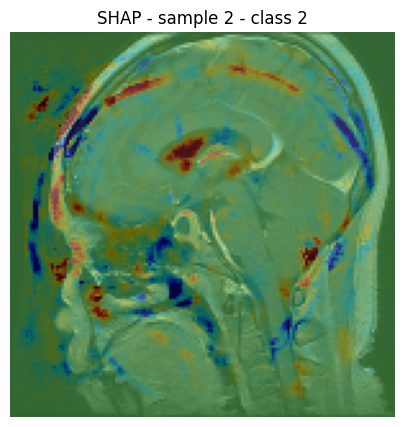

shap_arr.shape: (150, 150, 3, 4)
shap_map shape: (150, 150, 3)
shap_map_gray shape: (150, 150)


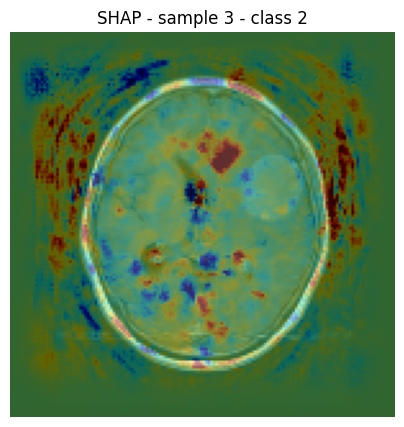

shap_arr.shape: (150, 150, 3, 4)
shap_map shape: (150, 150, 3)
shap_map_gray shape: (150, 150)


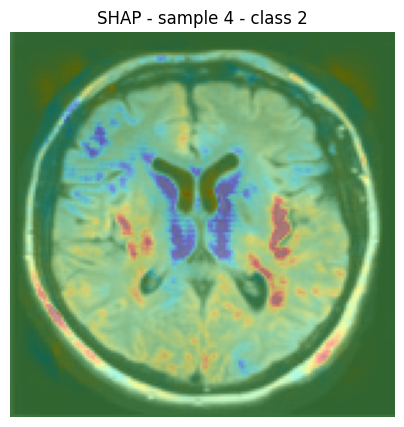

shap_arr.shape: (150, 150, 3, 4)
shap_map shape: (150, 150, 3)
shap_map_gray shape: (150, 150)


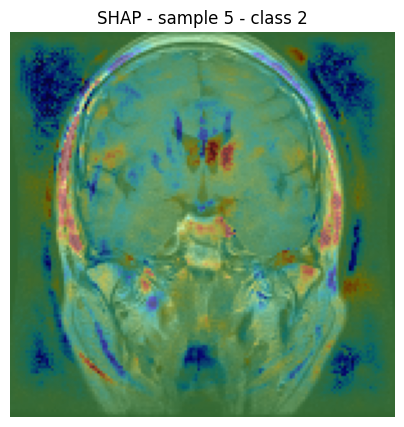

shap_arr.shape: (150, 150, 3, 4)
shap_map shape: (150, 150, 3)
shap_map_gray shape: (150, 150)


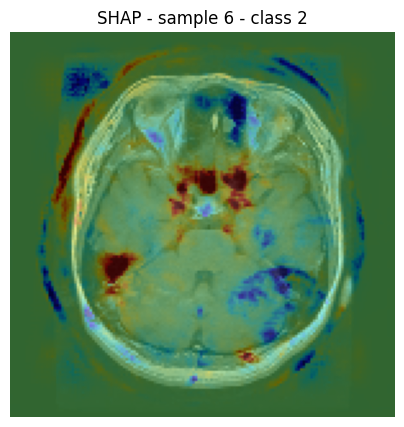

shap_arr.shape: (150, 150, 3, 4)
shap_map shape: (150, 150, 3)
shap_map_gray shape: (150, 150)


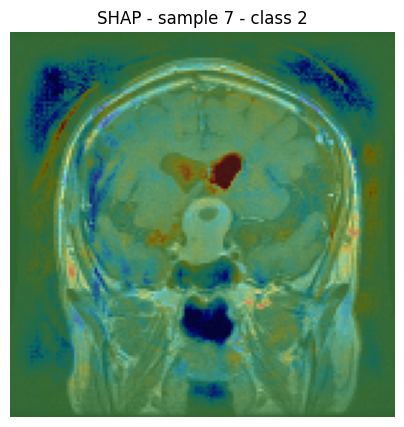

shap_arr.shape: (150, 150, 3, 4)
shap_map shape: (150, 150, 3)
shap_map_gray shape: (150, 150)


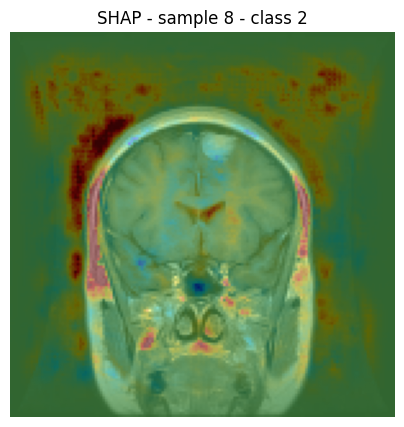

shap_arr.shape: (150, 150, 3, 4)
shap_map shape: (150, 150, 3)
shap_map_gray shape: (150, 150)


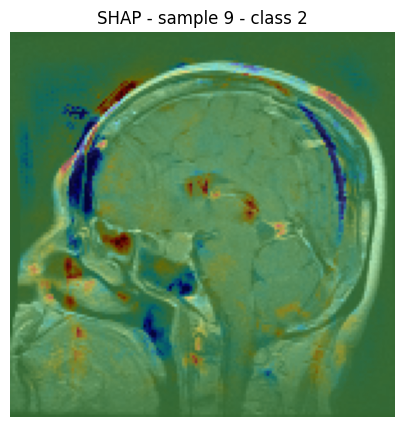

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

background = X_train[np.random.choice(len(X_train), 50, replace=False)]
explainer = shap.DeepExplainer(model, background)

for i, img in enumerate(X_test[20:30]):
    img_batch = img[np.newaxis, ...]  # shape (1, 150, 150, 3)
    shap_values = explainer.shap_values(img_batch)  # [array(150, 150, 3, 4)]
    shap_arr = shap_values[0]                       # not a list, shape (150, 150, 3, 4)
    print("shap_arr.shape:", shap_arr.shape)        # (150, 150, 3, 4)

    class_idx = 2                                   # YOUR target class
    shap_map = shap_arr[:, :, :, class_idx]         # (150, 150, 3)
    print("shap_map shape:", shap_map.shape)

    shap_map_gray = shap_map.mean(axis=-1)          # (150, 150)
    print("shap_map_gray shape:", shap_map_gray.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    vmax = np.percentile(np.abs(shap_map_gray), 99)
    plt.imshow(shap_map_gray, cmap='jet', alpha=0.4, vmin=-vmax, vmax=vmax)
    plt.title(f"SHAP - sample {i} - class {class_idx}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step


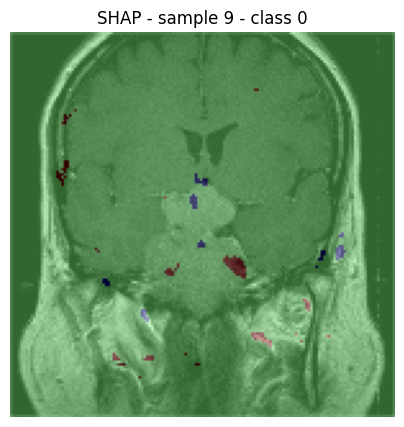

In [ ]:
img_batch = img[np.newaxis, ...]
pred_class = np.argmax(model.predict(img_batch), axis=1)[0]

shap_arr = shap_values[0]  # (150, 150, 3, 4)
shap_map = shap_arr[:, :, :, pred_class]
shap_map_gray = shap_map.mean(axis=-1)
threshold = np.percentile(np.abs(shap_map_gray), 99)
shap_map_thresh = np.where(np.abs(shap_map_gray) > threshold, shap_map_gray, 0)

plt.figure(figsize=(5,5))
plt.imshow(img)
vmax = np.percentile(np.abs(shap_map_thresh), 99)
plt.imshow(shap_map_thresh, cmap='jet', alpha=0.4, vmin=-vmax, vmax=vmax)
plt.title(f"SHAP - sample {i} - class {pred_class}")
plt.axis('off')
plt.show()

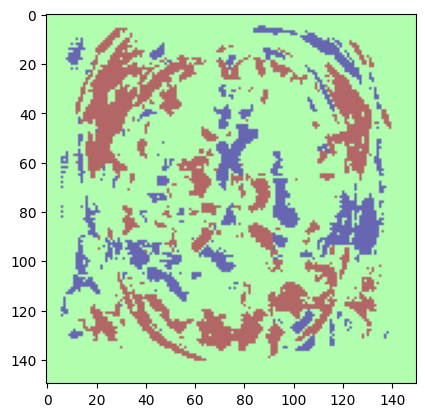

In [ ]:
threshold = np.percentile(np.abs(shap_map_gray), 75)
shap_map_thresh = np.where(np.abs(shap_map_gray) > threshold, shap_map_gray, 0)
plt.imshow(shap_map_thresh, cmap='jet', alpha=0.6, vmin=-vmax, vmax=vmax)
